In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from myScripts import featureengineering
from sklearn.pipeline import Pipeline, FeatureUnion
#feature_df = featureengineering.create_features('Analysis_dataset.csv')

In [2]:
df = pd.read_csv('Analysis_dataset.csv')\
.drop('Unnamed: 0', axis = 1)

In [3]:
from myScripts.featureengineering import CreateFeatures
custom_pipeline = Pipeline( steps = [('create_features', CreateFeatures())])
feature_df=custom_pipeline.fit_transform(df)
feature_df.head()

,,ratio_fraud_device_id,num_trans_device_id,ratio_fraud_country,num_trans_country,ratio_fraud_sex,num_trans_sex,age,ratio_fraud_age,num_trans_age,ratio_fraud_browser,num_trans_browser,ratio_fraud_source,num_trans_source,purchase_value,class,time_latency,country,sex,browser,source
user_id,device_id,,,,,,,,,,,,,,,,,,,,
285108,HZAKVUFTDOSFD,0.0,2.0,0.096830,46184.0,0.095442,70126,49,0.056534,1079.0,0.099441,48652,0.105643,24242,31,0,1377.683333,167,1,0,1
369076,HZAKVUFTDOSFD,0.0,2.0,0.115188,2344.0,0.095442,70126,43,0.084140,2686.0,0.091743,19620,0.091696,47461,40,0,1372.683333,30,1,4,0
131009,XGQAJSOUJIZCC,0.0,1.0,0.103911,3580.0,0.091671,49874,21,0.079291,2989.0,0.086107,29138,0.090109,48297,31,0,1888.400000,166,0,2,2
328855,VCCTAYDCWKZIY,0.0,1.0,0.096830,46184.0,0.095442,70126,26,0.076906,4460.0,0.086107,29138,0.105643,24242,16,0,611.483333,167,1,2,1
229053,MFFIHYNXCJLEY,0.0,1.0,0.091589,3341.0,0.095442,70126,34,0.088694,5006.0,0.099441,48652,0.090109,48297,29,0,44.883333,86,1,0,2


In [4]:
%matplotlib inline
import os
if os.path.exists("myScripts/apply_classifier_model.py"):
    os.remove("myScripts/apply_classifier_model.py")

In [5]:
%%writefile myScripts/apply_classifier_model.py

import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.base  import BaseEstimator,TransformerMixin
from matplotlib import pyplot as plt
class ApplyTrainTestSplit(BaseEstimator,TransformerMixin):
    def __init__(self,test_size):
        self.test_size=test_size
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return train_test_split(X.drop('class',axis=1),X['class'],test_size=self.test_size)
class ApplyRFClassifier(BaseEstimator,TransformerMixin):
    def __init__(self,model_path,n_estimators=50,random_state=0,n_jobs=-1):
        self.model_path=model_path
        self.n_estimators=n_estimators
        self.random_state=random_state
        self.n_jobs=n_jobs=-1
        
    def fit(self,X,y):
        self.X=X
        self.y=y
        self.RF_model=RandomForestClassifier(n_estimators=self.n_estimators, random_state=self.random_state, n_jobs=self.n_jobs)
        self.RF_model.fit(self.X,self.y)
        return self
    def transform(self,X):
        pickle_models(self.RF_model,self.model_path)
        return self.RF_model
class ApplyBalancedRFClassifier(BaseEstimator,TransformerMixin):
    def __init__(self,model_path,n_estimators=50,random_state=0,n_jobs=-1):
        self.n_estimators=n_estimators
        self.random_state=random_state
        self.n_jobs=n_jobs=-1
        self.model_path=model_path
    def fit(self,X,y):
        self.X=X
        self.y=y
        self.BRF_model=BalancedRandomForestClassifier(n_estimators=self.n_estimators, random_state=self.random_state, n_jobs=self.n_jobs)
        self.BRF_model.fit(self.X,self.y)
        return self
    def transform(self,X):
        pickle_models(self.BRF_model,self.model_path)
        return self.BRF_model
def calculate_loss(row):
    if (row['actual'] == 0) & (row['predicted']==1):
        row['loss'] = 8.0
    elif (row['actual'] == 1) & (row['predicted']==0):
        row['loss'] = row['purchase_value']
    else:
        row['loss'] = 0
    return row
def calculate_total_loss(X_test,y_test,y_pred):
    loss_df = X_test
    loss_df['actual'] = y_test
    loss_df['predicted'] = y_pred
    loss_df = loss_df.apply(calculate_loss, axis = 1)
    total_loss = loss_df.loss.sum()
    return total_loss
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`."""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def pickle_models(model,filename):
    '''pickles saved models in the specified path'''
    joblib.dump(model, filename)

def load_models(filename):
    '''loads trained model specified path'''
    return joblib.load(filename)

Writing myScripts/apply_classifier_model.py


In [6]:
from myScripts.apply_classifier_model import ApplyTrainTestSplit
X_train, X_test, y_train, y_test = ApplyTrainTestSplit(test_size = 0.2).fit_transform(feature_df)

C:\Python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


Normalized confusion matrix
[[0.995395 0.004605]
 [0.053392 0.946608]]


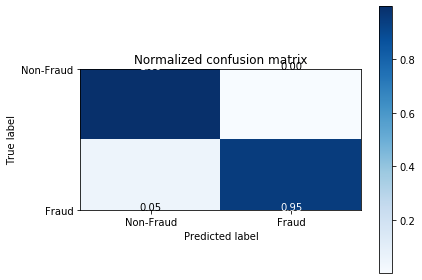

In [7]:
from myScripts.apply_classifier_model import ApplyRFClassifier
from myScripts.apply_classifier_model import plot_confusion_matrix
#from myScripts.apply_classifier_model import calculate_total_loss
from myScripts.apply_classifier_model import load_models
from sklearn.metrics import confusion_matrix

## Create and save models
RF_model = ApplyRFClassifier('RF_model.joblib').fit_transform(X_train,y_train)

# Predict the values using the Decision Tree Classifier
# Load from the pickled file
RF_model = load_models('RF_model.joblib')
RF_y_predicted = RF_model.predict(X_test)

## Predict probablities of Decision Tree Classifier
RF_y_pred_prob = RF_model.predict_proba(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, RF_y_predicted)
np.set_printoptions(precision=6)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Fraud', 'Fraud'], normalize=True,
                      title='Normalized confusion matrix')

Normalized confusion matrix
[[9.849873e-01 1.501266e-02]
 [4.376368e-04 9.995624e-01]]


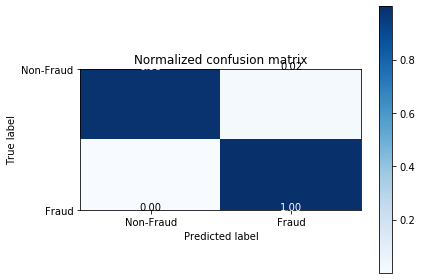

In [8]:
from myScripts.apply_classifier_model import ApplyBalancedRFClassifier


## Create and save models
BRF_model = ApplyBalancedRFClassifier('BRF_model.joblib').fit_transform(X_train,y_train)

# Predict the values using the Decision Tree Classifier
# Load from the pickled file
BRF_model = load_models('BRF_model.joblib')
BRF_y_predicted = BRF_model.predict(X_test)

# Predict the values using the Decision Tree Classifier
BRF_y_predicted = BRF_model.predict(X_test)

## Predict probablities of Decision Tree Classifier
BRF_y_pred_prob = BRF_model.predict_proba(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, BRF_y_predicted)
np.set_printoptions(precision=6)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Fraud', 'Fraud'], normalize=True,
                      title='Normalized confusion matrix')

In [9]:
from myScripts.apply_classifier_model import calculate_total_loss
# Calculate total loss in dollars using DT classifier
print('Total loss in dollar amounts using RF classifier = ', calculate_total_loss(X_test, y_test, RF_y_predicted))

# Calculate total loss in dollars using RF classifier
print('Total loss in dollar amounts using balanced RF classifier = ', calculate_total_loss(X_test, y_test, BRF_y_predicted))

Total loss in dollar amounts using RF classifier =  5223.0
Total loss in dollar amounts using balanced RF classifier =  2654.0
